In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.optimize import minimize
from numba import jit, njit
from scipy.stats import  t
import pandas as pd
from scipy.stats import norm, t


In [2]:
class StochasticProcess:
    def __init__(self, params, T, Nx, Nt, init_state = None):
        self.params = params
        self.T = T
        self.Nx = Nx # Number of trajectories
        self.Nt = Nt # Number of discretization steps
        self.init_state = init_state

    # Wiener Process by default
    # use @staticmethod for numba compatibility with @njit
    @staticmethod
    @njit
    def bxt(x, t, params):
        return 0

    @staticmethod
    @njit
    def sigmaxt(x, t, params):
        return 1

    @staticmethod
    @njit
    def bxt_x(x, t, params):
        return 0

    @staticmethod
    @njit
    def bxt_xx(x, t, params):
        return 0

    @staticmethod
    @njit
    def sigmaxt_x(x, t, params):
        return 0

    @staticmethod
    @njit
    def sigmaxt_xx(x, t, params):
        return 0

    @staticmethod
    @njit
    def bxt_t(x, t, params):
        return 0

    def DefaultInitState(self):
        return np.zeros(self.Nx)

    def EulerSolution(self, dwt = None):
        dt = self.T / self.Nt
        t_data = np.linspace(0, self.T, self.Nt + 1)
        x_data = np.zeros((self.Nt + 1, self.Nx))

        if dwt is None:
            dwt = np.random.normal(0, 1, size = (self.Nt, self.Nx)) * np.sqrt(dt)

        if self.init_state is None:
            x_data[0] = self.DefaultInitState()
        else:
            x_data[0] = self.init_state

        for i in range(1, self.Nt + 1):
            x_data[i] = x_data[i - 1] + self.bxt(x_data[i - 1], t_data[i - 1], self.params) * dt +\
                        self.sigmaxt(x_data[i - 1], t_data[i - 1], self.params) * dwt[i - 1]
        return t_data, x_data

    @staticmethod
    @njit
    def EulerDensity(x, t, x0, t0, params, bxt, bxt_x, bxt_xx, sigmaxt, sigmaxt_x, sigmaxt_xx, bxt_t):
        xs = x0 + bxt(x0, t0, params) * (t - t0)
        sigma2 = sigmaxt(x0, t0, params)**2 * (t - t0)

        return -1/2 * np.log(2 * np.pi * sigma2) - (x - xs)**2 / (2 * sigma2)

    @staticmethod
    @njit
    def OzakiDensity(x, t, x0, t0, params, bxt, bxt_x, bxt_xx, sigmaxt, sigmaxt_x, sigmaxt_xx, bxt_t):
        K = 1 / (t - t0) * np.log(1 + bxt(x0, t0, params) / (x0 * bxt_x(x0, t0, params)) * (np.exp(bxt_x(x0, t0, params) * (t - t0)) - 1))
        E = x0 + bxt(x0, t0, params) / bxt_x(x0, t0, params) * (np.exp(bxt_x(x0, t0, params) * (t - t0)) - 1)
        V = sigmaxt(x0, t0, params)**2 / (2 * K) * (np.exp(2 * K * (t - t0)) - 1)

        if K == 0:
            K = K + 0.001
        if E == 0:
            E = E + 0.001
        if V == 0:
            V = V + 0.001

        xs = E
        sigma2 = V

        return -1/2 * np.log(2 * np.pi * sigma2) - (x - xs)**2 / (2 * sigma2)

    @staticmethod
    @njit
    def ShojiOzakiDensity(x, t, x0, t0, params, bxt, bxt_x, bxt_xx, sigmaxt, sigmaxt_x, sigmaxt_xx, bxt_t):
        L = bxt_x(x0, t0, params)

        #safe division
        if L == 0:
            L = L + 0.001

        M = sigmaxt(x0, t0, params)**2 / 2 * bxt_xx(x0, t0, params) + bxt_t(x0, t0, params)

        A = 1 + bxt(x0, t0, params) / (x0 * L) * (np.exp(L * (t - t0)) - 1) + M / (x0 * L**2) * \
            (np.exp(L * (t - t0)) - 1 - L * (t - t0))
        B = sigmaxt(x0, t0, params)**2 * 1/(2 * L) * (np.exp(2 * L * (t - t0)) - 1)

        xs = A * x0
        sigma2 = B

        return -1/2 * np.log(2 * np.pi * sigma2) - (x - xs)**2 / (2 * sigma2)

    @staticmethod
    @njit
    def KesslerDensity(x, t, x0, t0, params, bxt, bxt_x, bxt_xx, sigmaxt, sigmaxt_x, sigmaxt_xx, bxt_t):
        E = x0 + bxt(x0, t0, params) * (t - t0) + (bxt(x0, t0, params) * bxt_x(x0, t0, params) + 1/2 * \
            sigmaxt(x0, t0, params)**2 * bxt_xx(x0, t0, params)) * 1/2 * (t - t0)**2
        V = x0**2 + (2 * bxt(x0, t0, params) * x0 + sigmaxt(x0, t0, params)**2 ) * (t - t0)\
            + (2 * bxt(x0, t0, params) * (bxt_x(x0, t0, params) * x0 + bxt(x0, t0, params) + \
                sigmaxt(x0, t0, params) * sigmaxt_x(x0, t0, params))\
            + sigmaxt(x0, t0, params)**2 * (bxt_xx(x0, t0, params) * x0 + 2 * bxt_x(x0, t0, params) +\
                sigmaxt_x(x0, t0, params)**2 + sigmaxt(x0, t0, params) * sigmaxt_xx(x0, t0, params))) * (t - t0)**2 / 2 - E**2

        xs = E

        #safe division
        if V == 0:
            V = V + 0.001

        sigma2 = V

        return -1/2 * np.log(2 * np.pi * sigma2) - (x - xs)**2 / (2 * sigma2)

    @staticmethod
    @njit
    def MLogLik(params, t_data, x_data, density, bxt, bxt_x, bxt_xx, sigmaxt, sigmaxt_x, sigmaxt_xx, bxt_t):
        Nt = len(x_data)
        Nx = len(x_data[0])
        log_data = np.zeros(Nx)
        for k in range(0, Nx):
            m_log_lik = 0
            for j in range(1, Nt):
                m_log_lik += density(x_data[j][k], t_data[j], x_data[j - 1][k], t_data[j - 1], params,
                                     bxt, bxt_x, bxt_xx, sigmaxt, sigmaxt_x, sigmaxt_xx, bxt_t)
            log_data[k] = m_log_lik

        res = -np.mean(log_data)
        return res

    def EulerEstimation(self, t_data, x_data):
        x0 = np.ones(len(self.params))
        accuracy = 1e-8

        min_result = minimize(self.MLogLik,
                              x0 = x0,
                              args=(t_data, x_data, self.EulerDensity,
                              self.bxt, self.bxt_x, self.bxt_xx, self.sigmaxt, self.sigmaxt_x, self.sigmaxt_xx,
                              self.bxt_t),
                              method = 'L-BFGS-B',
                              options={'ftol': accuracy, 'eps': accuracy})
        return min_result

    def OzakiEstimation(self, t_data, x_data):
        x0 = np.ones(len(self.params))
        accuracy = 1e-8

        min_result = minimize(self.MLogLik,
                              x0 = x0,
                              args=(t_data, x_data, self.OzakiDensity,
                              self.bxt, self.bxt_x, self.bxt_xx, self.sigmaxt, self.sigmaxt_x, self.sigmaxt_xx,
                              self.bxt_t),
                              method = 'L-BFGS-B',
                              options={'ftol': accuracy, 'eps': accuracy})
        return min_result

    def ShojiOzakiEstimation(self, t_data, x_data):
        x0 = np.ones(len(self.params))
        accuracy = 1e-8

        min_result = minimize(self.MLogLik,
                              x0 = x0,
                              args=(t_data, x_data, self.ShojiOzakiDensity,
                              self.bxt, self.bxt_x, self.bxt_xx, self.sigmaxt, self.sigmaxt_x, self.sigmaxt_xx,
                              self.bxt_t),
                              method = 'L-BFGS-B',
                              options={'ftol': accuracy, 'eps': accuracy})
        return min_result

    def KesslerEstimation(self, t_data, x_data):
        x0 = np.ones(len(self.params))
        accuracy = 1e-8

        min_result = minimize(self.MLogLik,
                              x0 = x0,
                              args=(t_data, x_data, self.KesslerDensity,
                              self.bxt, self.bxt_x, self.bxt_xx, self.sigmaxt, self.sigmaxt_x, self.sigmaxt_xx,
                              self.bxt_t),
                              method = 'L-BFGS-B',
                              options={'ftol': accuracy, 'eps': accuracy})
        return min_result


class OUprocess(StochasticProcess):
    def __init__(self, params, T, Nx, Nt, init_state = None):
        super().__init__(params, T, Nx, Nt, init_state)

    # params = [theta, mu, sigma]

    @staticmethod
    @njit
    def bxt(x, t, params):
        return params[0] * (params[1] - x)

    @staticmethod
    @njit
    def sigmaxt(x, t, params):
        return params[2]

    @staticmethod
    @njit
    def bxt_x(x, t, params):
        return -params[0]

    def DefaultInitState(self):
        return self.params[1] * np.ones(self.Nx)

class CKLSprocess(StochasticProcess):
    def __init__(self, params, T, Nx, Nt, init_state = None):
        super().__init__(params, T, Nx, Nt, init_state)

    # params = [theta1, theta2, theta3]
    @staticmethod
    @njit
    def bxt(x, t, params):
        return params[0] + params[1] * x

    @staticmethod
    @njit
    def sigmaxt(x, t, params):
        return params[2] * x**params[3]

    @staticmethod
    @njit
    def bxt_x(x, t, params):
        return params[1]

    @staticmethod
    @njit
    def sigmaxt_x(x, t, params):
        return params[2] * params[3] * x**(params[3] - 1)

    @staticmethod
    @njit
    def sigmaxt_xx(x, t, params):
        return params[2] * params[3] * (params[3] - 1) * x**(params[3] - 2)

    def DefaultInitState(self):
        return self.params[0] / self.params[1] * np.ones(self.Nx)

class Task5process(StochasticProcess):
    def __init__(self, params, T, Nx, Nt, init_state = None):
        super().__init__(params, T, Nx, Nt, init_state)

    # params = [theta1, theta2]
    @staticmethod
    @njit
    def bxt(x, t, params):
        return params[0] * t * x

    @staticmethod
    @njit
    def sigmaxt(x, t, params):
        return params[1] * x

    @staticmethod
    @njit
    def bxt_x(x, t, params):
        return params[0] * t

    @staticmethod
    @njit
    def sigmaxt_x(x, t, params):
        return params[1]

    @staticmethod
    @njit
    def bxt_t(x, t, params):
        return params[0] * x

    def DefaultInitState(self):
        return self.params[0] / self.params[1] * np.ones(self.Nx)

class HullWhiteprocess(StochasticProcess):
    def __init__(self, params, T, Nx, Nt, init_state = None):
        super().__init__(params, T, Nx, Nt, init_state)

    # params = [theta1, theta2, theta3]
    @staticmethod
    @njit
    def bxt(x, t, params):
        return params[0] * t * (params[1] * np.sqrt(t) - x)

    @staticmethod
    @njit
    def sigmaxt(x, t, params):
        return params[2] * t

    @staticmethod
    @njit
    def bxt_x(x, t, params):
        return -params[0] * t

    @staticmethod
    @njit
    def bxt_t(x, t, params):
        return params[0] * params[1] * 3/2 * np.sqrt(t)

    def DefaultInitState(self):
        return self.params[1] * np.ones(self.Nx)

Task 1. Evaluate the conditional density of the Ornstein-Uhlenbeck process
$$dX_t = (3-X_t)dt+2dW_t, \quad X_0=1, \quad %\theta=(1, 3, 2), \quad
N=100000,
\quad \Delta=1$$ and calculate the
maximum likelihood estimation.  

In [3]:
Nx = 1000
Nt = 300

T = 1

params_OU = np.array([3, 1, 2])

x0 = 1
init_state = x0 * np.ones(Nx)

OUp = OUprocess(params_OU, T, Nx, Nt, init_state)

t_data, x_data_OU = OUp.EulerSolution()

In [4]:
OUp.EulerEstimation(t_data, x_data_OU)

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: -222.181263893808
        x: [ 2.972e+00  1.016e+00  1.998e+00]
      nit: 14
      jac: [ 3.695e-05  1.421e-04  1.990e-05]
     nfev: 72
     njev: 18
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>

In [5]:
OUp.ShojiOzakiEstimation(t_data, x_data_OU)

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: -222.1812639051528
        x: [ 2.987e+00  1.016e+00  2.008e+00]
      nit: 15
      jac: [ 0.000e+00  7.105e-05  1.592e-04]
     nfev: 64
     njev: 16
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>

In [6]:
OUp.KesslerEstimation(t_data, x_data_OU)

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: -222.1812650743704
        x: [ 2.986e+00  1.016e+00  2.008e+00]
      nit: 15
      jac: [-5.969e-05 -4.263e-05 -6.509e-04]
     nfev: 64
     njev: 16
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>

Task. Find the maximum likelihood estimators  numerically
 for Ornstein-Uhlenbeck process
 $$
 dX_t = -\theta_2X_tdt + \theta_3dW_t, \quad \theta=(0, 3, 2), \quad
N=1000, \quad \Delta=1
$$
and compare with explicit estimations

$$
\hat{\theta}_{2,n} = -\frac{1}{\Delta}\log \left(\frac{\sum_{i=1}^n X_{i-1}X_i} {\sum_{i=1}^n X^2_{i-1}}\right),
$$
$$
\hat{\theta}_{3,n} = \sqrt{\frac{2\hat{\theta}_{2,n}}
{n(1 - e^{-2\Delta  \hat{\theta}_{2,n}})}
\sum_{i=1}^n (X_i- X_{i-1} e^{-\Delta \hat{\theta}_{2, n}})^2}.
$$

In [7]:
# явные оценки
def explicit_theta2(X, delta):
    return -1 / delta * np.log(np.sum(X[:-1] * X[1:]) / np.sum(X[:-1]**2))

def explicit_theta3(X, theta2_hat, delta):
    n = len(X) - 1
    term = np.sum((X[1:] - X[:-1] * np.exp(-theta2_hat * delta))**2)
    return np.sqrt((2 * theta2_hat) / (n * (1 - np.exp(-2 * delta * theta2_hat))) * term)

In [8]:
Nx = 1000
Nt = 300

T = 1
delta = 1

params_OU = np.array([0, 3, 2])

x0 = 1
init_state = x0 * np.ones(Nx)

OUp = OUprocess(params_OU, T, Nx, Nt, init_state)

t_data, x_data_OU = OUp.EulerSolution()

In [9]:
euler_OUp = OUp.EulerEstimation(t_data, x_data_OU)
kessler_OUp = OUp.KesslerEstimation(t_data, x_data_OU)
ozaki_OUp = OUp.ShojiOzakiEstimation(t_data, x_data_OU)

In [10]:
print(euler_OUp.x)
print(kessler_OUp.x)
print(ozaki_OUp.x)

[0.03415542 1.08469395 1.99994901]
[0.03455086 1.08926478 2.00006386]
[0.03457016 1.08905411 2.0000637 ]


In [11]:
theta2_explicit = explicit_theta2(x_data_OU.flatten(), delta)  # Все данные во временной последовательности
theta3_explicit = explicit_theta3(x_data_OU.flatten(), theta2_explicit, delta)  # Все данные
print(theta2_explicit, theta3_explicit)


1.0273011792957025 2.5222977367565496


Task 3. Consider  the Chan-Karolyi-Longstaff-Sanders (CKLS) model
$$
 dX_{t} = (\theta_{1}+\theta_{2} X_{t}) dt + \theta_{3} X_{t}^{\theta_{4}} dW_{t},\qquad X_{0}=2
$$
with $\theta_{1}=1$, $\theta_{2}=2$, $\theta_{3}=0.5$, $\theta_{4}=0.3$.

Use the Euler method and
* generate the sample data $X_{t_i}$ with time step $\Delta t =10^{-4}$,  
* estimate drift and diffusion coefficients,
* compute confidence intervals for all parameters in a fitted SDE.  


In [12]:
Nx = 1
Nt = 10000

T = 1

params_CKLS = np.array([1, 2, 0.5, 0.3])

x0 = 2
init_state = x0 * np.ones(Nx)

CKLSp = CKLSprocess(params_CKLS, T, Nx, Nt, init_state)

t_data, x_data_CKLS = CKLSp.EulerSolution()

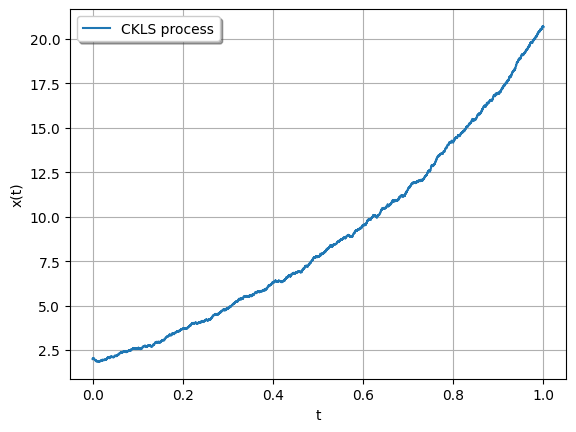

In [13]:
plt.plot(t_data, x_data_CKLS[:,0], label = 'CKLS process')

plt.legend(loc = 'best', fancybox = True, shadow = True)
plt.xlabel("t")
plt.ylabel("x(t)")
plt.grid(True)
plt.show()

In [14]:
CKLSp.EulerEstimation(t_data, x_data_CKLS)

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: -32811.40169086473
        x: [ 1.109e+00  1.940e+00  5.154e-01  2.880e-01]
      nit: 19
      jac: [-1.219e+00  1.193e-01  2.525e-01  4.948e-02]
     nfev: 120
     njev: 24
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>

In [15]:
#Confidence intervals
n = 50
result = np.zeros((n, 4))
for k in range(0, n):
    t_data, x_data_CKLS = CKLSp.EulerSolution()
    result[k] = CKLSp.EulerEstimation(t_data, x_data_CKLS).x


alpha = 0.05
q = t.ppf(1-alpha/2, n - 1)
for i in range(0, 4):
    m = np.mean(result[:,i])
    v = np.std(result[:,i], ddof=1)
    print(f"theta{i} = {m} +- {v * q / np.sqrt(n)} with {100 - alpha * 100}% prob")

theta0 = 0.9619099660002038 +- 0.2499785734659701 with 95.0% prob
theta1 = 1.9745843369126208 +- 0.050277432192930134 with 95.0% prob
theta2 = 0.4976403081898893 +- 0.0030722487235155887 with 95.0% prob
theta3 = 0.3030960204591601 +- 0.0033723079848373204 with 95.0% prob


Task 4. Consider the Vasicek model
$$
dX_{t} = \theta_{1} (\theta_{2}- X_{t}) dt + \theta_{3} dW_{t},\qquad X_{0}=5
$$
with $\theta_{1}=3$, $\theta_{2}=2$ and $\theta_{3}=0.5$.

Use the Ozaki method and
*   generate the sample data $X_{t_i}$, time step $\Delta t =10^{-2}$,
*   estimate drift and diffusion coefficients,
*   compute confidence intervals for all parameters in a fitted SDE.

In [16]:
Nx = 1
Nt = 100

T = 1

params_OU = np.array([3, 2, 0.5])

x0 = 5
init_state = x0 * np.ones(Nx)

OUp = OUprocess(params_OU, T, Nx, Nt, init_state)

t_data, x_data_OU = OUp.EulerSolution()

In [17]:
# x_data_OU

In [18]:
OUp.OzakiEstimation(t_data, x_data_OU)

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: -157.78104223681797
        x: [ 2.143e+00  1.548e+00  5.018e-01]
      nit: 16
      jac: [-5.116e-05  9.663e-05 -1.108e-04]
     nfev: 96
     njev: 24
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>

In [19]:
#Confidence intervals
n = 50
result = np.zeros((n, 3))
for k in range(0, n):
    t_data, x_data_OU = OUp.EulerSolution()
    result[k] = OUp.OzakiEstimation(t_data, x_data_OU).x


alpha = 0.05
q = t.ppf(1-alpha/2, n - 1)
for i in range(0, 3):
    m = np.mean(result[:,i])
    v = np.std(result[:,i], ddof=1)
    print(f"theta{i} = {m} +- {v * q / np.sqrt(n)} with {100 - alpha * 100}% prob")

theta0 = 3.332020506062367 +- 0.1825167105838363 with 95.0% prob
theta1 = 1.9984356428763492 +- 0.05552444616140356 with 95.0% prob
theta2 = 0.41574616246314056 +- 0.0773342360731056 with 95.0% prob


Task 5. Consider the model
$$
  dX_{t} = a(t)X_{t} dt + \theta_{2}X_{t} dW_{t},\qquad X_{0}=10
$$
with $a(t) = \theta_{1}t$, $\theta_{1}=-2$, $\theta_{2}=0.2$.

Use the Shoji-Ozaki method and:
* generate the sample data $X_{t_i}$ time step $\Delta t =10^{-3}$,  
* estimate drift and diffusion coefficients,
* compute confidence intervals for all parameters in a fitted SDE.

In [20]:
Nx = 1
Nt = 1000

T = 1

params_T5 = np.array([-2, 0.2])

x0 = 5
init_state = x0 * np.ones(Nx)

T5p = Task5process(params_T5, T, Nx, Nt, init_state)

t_data, x_data_T5 = T5p.EulerSolution()

In [21]:
T5p.ShojiOzakiEstimation(t_data, x_data_T5)

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: -2342.816261975101
        x: [-1.687e+00  2.028e-01]
      nit: 15
      jac: [-1.269e-02  9.049e-03]
     nfev: 66
     njev: 22
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>

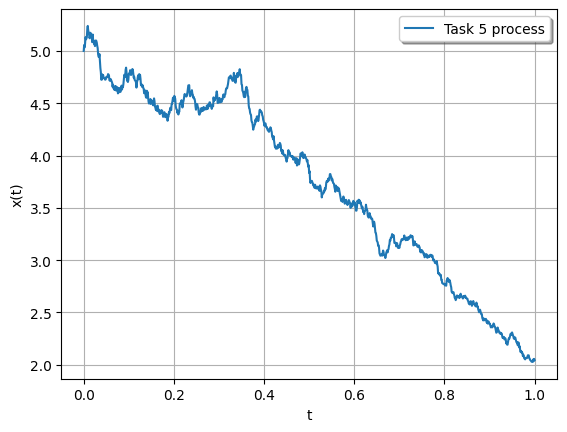

In [22]:
plt.plot(t_data, x_data_T5[:,0], label = 'Task 5 process')

plt.legend(loc = 'best', fancybox = True, shadow = True)
plt.xlabel("t")
plt.ylabel("x(t)")
plt.grid(True)
plt.show()

In [23]:
#Confidence intervals
n = 50
result = np.zeros((n, 2))
for k in range(0, n):
    t_data, x_data_T5 = T5p.EulerSolution()
    result[k] = T5p.ShojiOzakiEstimation(t_data, x_data_T5).x


alpha = 0.05
q = t.ppf(1-alpha/2, n - 1)
for i in range(0, 2):
    m = np.mean(result[:,i])
    v = np.std(result[:,i], ddof=1)
    print(f"theta{i} = {m} +- {v * q / np.sqrt(n)} with {100 - alpha * 100}% prob")

theta0 = -2.039034925318457 +- 0.09364138465659283 with 95.0% prob
theta1 = 0.20010613404752853 +- 0.0013452148228816983 with 95.0% prob


### Task 6. Consider the Hull-White (extended Vasicek) model
$$
  dX_{t} = a(t)(b(t)-X_{t}) dt + \sigma(t) dW_{t},\qquad X_{0}=2
$$
with $a(t) = \theta_{1}t$, $b(t)=\theta_{2}\sqrt{t}$, the volatility depends on time $\sigma(t)=\theta_{3}t$.

Generate sample data of $X_t$ with time step $\Delta t =10^{-3}$ and $\theta_{1}=3$, $\theta_{2}=1$ and $\theta_{3}=0.3$, then
use the Kessler method and:
*   estimate drift and diffusion coefficients,
*   compute confidence intervals for all parameters in a fitted SDE.

In [24]:
Nx = 1
Nt = 100

T = 1

params_HW = np.array([3, 1, 0.3])

x0 = 2
init_state = x0 * np.ones(Nx)

HWp = HullWhiteprocess(params_HW, T, Nx, Nt, init_state)

t_data, x_data_HW = HWp.EulerSolution()

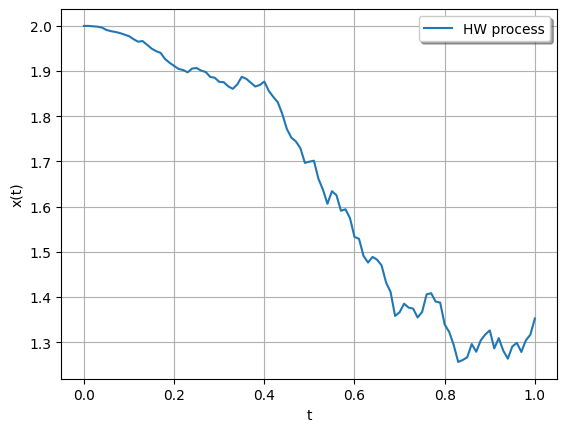

In [25]:
plt.plot(t_data, x_data_HW[:,0], label = 'HW process')

plt.legend(loc = 'best', fancybox = True, shadow = True)
plt.xlabel("t")
plt.ylabel("x(t)")
plt.grid(True)
plt.show()

In [26]:
HWp.KesslerEstimation(t_data, x_data_HW)

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: -301.89941517342714
        x: [ 2.675e+00  1.286e+00  3.143e-01]
      nit: 12
      jac: [ 1.348e-01  8.495e-02  2.769e-01]
     nfev: 100
     njev: 25
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>

Task. Take a process from previous tasks and approximation method, find the solution, compute confidence intervals, and compare results with baseline.
Plot the graph and table.

Задания по вариантам
1. Байков Илья Павлович OU + Kessler
1. Гонгапшев Астемир Султанович CKLS + Shoji-Ozaki
1. Кудинкина Екатерина Андреевна CKLS + Kessler
1. Кулига Андрей Владимирович Vasicek + Euler
1. Мартыненко Александр Станиславович Vasicek + Shoji-Ozaki
1. Мироманов Даниил Борисович Vasicek + Kessler
1. Паршаков Никита Сергеевич extended Vasicek + Euler
1. Петренко Влада Витальевна extended Vasicek + Ozaki
1. Тумачев Серафим Дмитриевич extended Vasicek + Shoji-Ozaki
1. Хубиев Касымхан Юсуфович model 5 + Euler
1. Ширяева Софья Игоревна model 5 + Ozaki
1. Якунин Сергей Александрович model 5 + Kessler
1. Трофимов Яков Георгиевич CKLS + Ozaki


### Extended Vasicek + Ozaki

/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


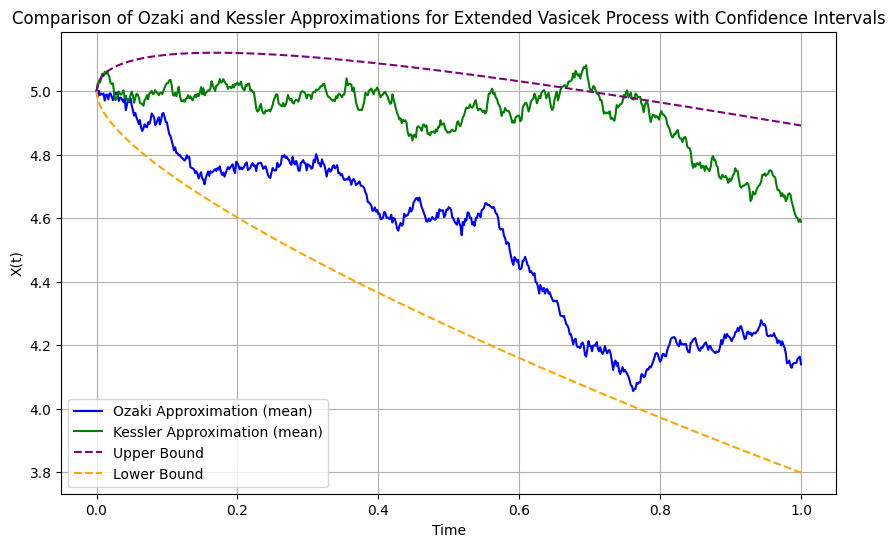

     Time     Ozaki  Kessler (baseline)  Difference (Ozaki - Kessler)
0     0.0  5.000000            5.000000                      0.000000
60    0.1  4.901495            5.024899                     -0.123404
120   0.2  4.773033            5.027077                     -0.254044
180   0.3  4.769912            4.988809                     -0.218897
240   0.4  4.613106            5.004375                     -0.391270
300   0.5  4.634764            4.870691                     -0.235927
360   0.6  4.442930            4.921057                     -0.478127
420   0.7  4.198122            5.008965                     -0.810843
480   0.8  4.149160            4.928241                     -0.779080
540   0.9  4.219718            4.717787                     -0.498069
600   1.0  4.140235            4.589054                     -0.448819


In [27]:
# сonfidence interval bounds
def Vasicek_bounds(alpha_interval, params, t, s, xs):
    theta1, theta2, theta3 = params  # alpha, mu, sigma
    alpha, mu, sigma = theta1, theta2, theta3

    mean_t = mu + (xs - mu) * np.exp(-alpha * (t - s))
    variance_t = (sigma**2 / (2 * alpha)) * (1 - np.exp(-2 * alpha * (t - s)))

    z_score = norm.ppf(1 - alpha_interval / 2)
    lower_bound = mean_t - z_score * np.sqrt(variance_t)
    upper_bound = mean_t + z_score * np.sqrt(variance_t)

    return [lower_bound, upper_bound]


# Vasicek process
def vasicek_process(X0, alpha, mu, sigma, T, dt, method='ozaki'):
    steps = int(T / dt)
    X = np.zeros(steps + 1)
    X[0] = X0

    for i in range(1, steps + 1):
        drift = alpha * (mu - X[i - 1]) * dt
        diffusion = sigma * np.sqrt(dt) * np.random.normal()

        if method == 'ozaki':
            X[i] = X[i - 1] + drift + diffusion
        elif method == 'kessler':
            X[i] = X[i - 1] + drift + diffusion + 0.5 * sigma**2 * dt

    return X

theta1, theta2, theta3 = 0.15, 0.3, 0.3
X0 = 5
T = 1
dt = 1 / 600
steps = int(T / dt)
alpha_interval = 0.05  # сonfidence level for bounds (e.g., 95%)

t_data = np.linspace(0, T, steps + 1)

# Ozaki and Kessler simulations
num_simulations = 1
np.random.seed(30)

simulations_ozaki = np.array([vasicek_process(X0, theta1, theta2, theta3, T, dt, method='ozaki') for _ in range(num_simulations)])
simulations_kessler = np.array([vasicek_process(X0, theta1, theta2, theta3, T, dt, method='kessler') for _ in range(num_simulations)])

# Mean and standard deviation of simulations
mean_ozaki = np.mean(simulations_ozaki, axis=0)
std_dev_ozaki = np.std(simulations_ozaki, axis=0, ddof=1)
mean_kessler = np.mean(simulations_kessler, axis=0)
std_dev_kessler = np.std(simulations_kessler, axis=0, ddof=1)

# Confidence bounds using Vasicek_bounds
low_bound_data = np.zeros_like(t_data)
up_bound_data = np.zeros_like(t_data)

for i in range(1, len(t_data)):
    bounds = Vasicek_bounds(alpha_interval, [theta1, theta2, theta3], t_data[i], 0, X0)
    low_bound_data[i] = bounds[0]
    up_bound_data[i] = bounds[1]
low_bound_data[0] = X0
up_bound_data[0] = X0

plt.figure(figsize=(10, 6))
plt.plot(t_data, mean_ozaki, label="Ozaki Approximation (mean)", color="blue")
plt.plot(t_data, mean_kessler, label="Kessler Approximation (mean)", color="green")
plt.plot(t_data, up_bound_data, '--', color="purple", label="Upper Bound")
plt.plot(t_data, low_bound_data, '--', color="orange", label="Lower Bound")
plt.xlabel("Time")
plt.ylabel("X(t)")
plt.legend()
plt.title("Comparison of Ozaki and Kessler Approximations for Extended Vasicek Process with Confidence Intervals")
plt.grid()
plt.show()

# Creating a DataFrame for the difference between Ozaki and Kessler means
diff_ozaki_kessler = mean_ozaki - mean_kessler
df = pd.DataFrame({
    "Time": t_data,
    "Ozaki": mean_ozaki,
    "Kessler (baseline)": mean_kessler,
    "Difference (Ozaki - Kessler)": diff_ozaki_kessler
})

# Sampling the DataFrame at regular intervals for inspection
step_index = int(0.1 / dt)
df_step_0_1 = df.iloc[::step_index]
print(df_step_0_1)



In [28]:
# Confidence intervals for parameter estimates
num_simulations = 10
q = t.ppf(1 - alpha_interval / 2, n - 1)

simulations_ozaki = np.array([vasicek_process(X0, theta1, theta2, theta3, T, dt, method='ozaki') for _ in range(num_simulations)])
simulations_kessler = np.array([vasicek_process(X0, theta1, theta2, theta3, T, dt, method='kessler') for _ in range(num_simulations)])

print("Ozaki Method:")
for i in range(4):
    m = np.mean(simulations_ozaki[:, i])
    v = np.std(simulations_ozaki[:, i], ddof=1)
    ci = v * q / np.sqrt(n)
    print(f"theta{i} = {m:.4f} ± {ci:.4f} with {100 - alpha_interval * 100}% confidence")

print("\nKessler Method:")
for i in range(4):
    m = np.mean(simulations_kessler[:, i])
    v = np.std(simulations_kessler[:, i], ddof=1)
    ci = v * q / np.sqrt(n)
    print(f"theta{i} = {m:.4f} ± {ci:.4f} with {100 - alpha_interval * 100}% confidence")

Ozaki Method:
theta0 = 5.0000 ± 0.0000 with 95.0% confidence
theta1 = 5.0004 ± 0.0021 with 95.0% confidence
theta2 = 5.0014 ± 0.0031 with 95.0% confidence
theta3 = 5.0052 ± 0.0048 with 95.0% confidence

Kessler Method:
theta0 = 5.0000 ± 0.0000 with 95.0% confidence
theta1 = 4.9959 ± 0.0040 with 95.0% confidence
theta2 = 4.9946 ± 0.0047 with 95.0% confidence
theta3 = 4.9945 ± 0.0069 with 95.0% confidence
